In [5]:
%matplotlib qt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
import os, glob
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Set up parameter variables

In [7]:
epochs = 1
batch_size = 64
random_seed = 10
# Select between 'large_filter_cnn' or 'binary_then_multiclass'
cnn_to_use = 'binary_then_multiclass'

# Load simulation data
#sim_data_path = glob.glob('*PX*.npz')[0]
sim_data_path = glob.glob('*K*.npz')[0]
print(sim_data_path)

IndexError: list index out of range

## Load data and reshape

In [4]:
npz_simulated_data = np.load(sim_data_path)

sim_data = npz_simulated_data['x']
phase_names = npz_simulated_data['phases']
phase_names = [s for s in phase_names]

# Reshape to just (data, label)
sim_data = sim_data.reshape(-1, sim_data.shape[-1])

# Create labels
n_phases = len(phase_names)
sim_labels = np.zeros((n_phases, int(sim_data.shape[0]/n_phases)))
for i in range(n_phases):
    sim_labels[i,:] = i
sim_labels = sim_labels.flatten()
print(phase_names)

['p4mbm_scaled_mixed_halide', 'gratia_2h', 'pbi2_2h']


## Create training and testing datasets

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(sim_data, sim_labels,
                                                                    test_size=0.25,
                                                                    random_state=random_seed)
print('train_data & train_labels:')
print(np.shape(train_data), np.shape(train_labels))
print('test_data & test_labels:')
print(np.shape(test_data), np.shape(test_labels))
print(test_labels[:5])

train_data & train_labels:
(67500, 147) (67500,)
test_data & test_labels:
(22500, 147) (22500,)
[1. 1. 2. 2. 0.]


## Connect to `neptune.io` and start experiment

In [6]:

PARAMS = {
'n_classes': len(phase_names),
'epochs': epochs,
'batch_size': batch_size,
'cnn_to_use': cnn_to_use,
}

tags = [cnn_to_use] + phase_names

project_name = 'ml_sed_cambridge/mini2-anish'

# Connect your script to Neptune
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlYWE5ZGEyNy1kZWU0LTQzN2MtOTE4YS03Y2VlMDcyMTRmYTMifQ==',
                   project=project_name, tags=tags)

run['source_code/model/my_params'].log(PARAMS)
run['source_code/simulation_dataset_name'].log(os.path.basename(sim_data_path))


https://app.neptune.ai/ml_sed_cambridge/mini2-anish/e/MINI2-25
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Prepare training and testing datasets
Create the binary labels, then filter out class == 0 and create train/test data/labels for categorical CNN.

In [90]:
def convert_labels_to_binary(labels_list, category_n_to_binarise=0):

    binary_labels = np.ones((len(labels_list), 1))
    for i in range(len(labels_list)):
        if labels_list[i] == category_n_to_binarise:
            binary_labels[i] = 0
    return binary_labels.flatten()

# Convert full train/test lables to binary lables
train_labels_bin = convert_labels_to_binary(train_labels)
test_labels_bin = convert_labels_to_binary(test_labels)

# Filter out category to binarise (perovskite) out, then convert to categorical
subtrain_data = []
subtrain_labels = []
subtest_data = []
subtest_labels = []

category_n_to_binarise = 0
for i in range(len(train_labels)):
    if train_labels[i] != category_n_to_binarise:
        subtrain_data.append(train_data[i])
        subtrain_labels.append(train_labels[i])

for i in range(len(test_labels)):
    if test_labels[i] != category_n_to_binarise:
        subtest_data.append(test_data[i])
        subtest_labels.append(test_labels[i])

subtrain_data = np.array(subtrain_data)
subtest_data = np.array(subtest_data)
print(subtrain_labels[:5])
print(np.shape(subtrain_data), np.shape(subtrain_labels))

# Shift all data to range (0, n)
# Need to subtract 1
subtrain_labels = [l-1 for l in subtrain_labels]
subtest_labels = [l-1 for l in subtest_labels]

# Check length of phases after filtering out one phase
if n_phases - 1 == 2:
    # Only 2 phases are left, leave it as binary (no need for categorical labels)
    subtrain_labels = np.array(subtrain_labels)
    subtest_labels = np.array(subtest_labels)
    print('This is a second binary problem!')
else:
    # More than 2 phases are left, need to categorize the data
    # Reshape to create categorical labels (instead of value from 0-n, get an n-array with 0s and 1)
    from tensorflow.keras.utils import to_categorical
    subtrain_labels = np.array(to_categorical(subtrain_labels))
    subtest_labels = np.array(to_categorical(subtest_labels))
    print(f'This is a categorical problem with {n_phases - 1}')

subtrain_labels[:5]

[1.0, 2.0, 1.0, 2.0, 2.0]
(45044, 147) (45044,)
This is a second binary problem!


array([0., 1., 0., 1., 1.])

## Create Neural Network

In [30]:
def create_large_filter_model(input_shape, output_classes):
    conv1d_filters = 64
    conv1d_kernel_size = 6
    deep_layer_input = 128
    max_pooling = 2
    dropout_rate = 0.5
    if output_classes == 2:
        final_activation_func = 'sigmoid'
        loss_function = 'binary_crossentropy'
        output_layer_points = 1
    else:
        final_activation_func = 'softmax'
        loss_function = 'categorical_crossentropy'
        output_layer_points = output_classes

    model = Sequential()
    model.add(tf.keras.layers.Conv1D(conv1d_filters, conv1d_kernel_size,
                                     input_shape=input_shape,
                                     data_format='channels_last',
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(max_pooling))
    model.add(tf.keras.layers.Conv1D(conv1d_filters, conv1d_kernel_size,
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(max_pooling))
    model.add(Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv1D(conv1d_filters, conv1d_kernel_size,
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(max_pooling))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(deep_layer_input, activation = 'relu'))
    model.add(tf.keras.layers.Dense(output_layer_points,  activation=final_activation_func))
    model.compile(loss=loss_function,
                  optimizer = 'adam',
                  metrics=['accuracy'])
    return model

In [31]:
# Create the two models
if cnn_to_use == 'large_filter_cnn':
    raise NotImplementedError("Please use the other notebook provided")

#Model A - Binary
input_shape = (train_data[0].size, 1)
output_classes = 2
print(input_shape, output_classes)
model_1 = create_large_filter_model(input_shape, output_classes)

#Model B - Binary or categorical, depending on how many phases
input_shape = (subtrain_data[0].size, 1)
output_classes = n_phases - 1
model_2 = create_large_filter_model(input_shape, output_classes)

model_1.summary(), model_2.summary()

(147, 1) 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 142, 64)           448       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 71, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 66, 64)            24640     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 33, 64)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 33, 64)            0         
                                                                 
 conv1d_8 (Conv1D)           (None, 28, 64)

(None, None)

In [32]:
batch_size = PARAMS['batch_size']
epochs =  PARAMS['epochs']

from neptune.new.integrations.tensorflow_keras import NeptuneCallback
neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics/train_1')

# Train and test model 1

In [33]:
train_data.shape

(67500, 147)

In [34]:
history = model_1.fit(train_data, train_labels_bin,
          batch_size=batch_size, epochs=epochs,
          callbacks=[neptune_cbk])

1055/1055 [==============================] - 55s 49ms/step - loss: 0.2613 - accuracy: 0.8820

In [35]:
accuracy_train_binary = model_1.evaluate(train_data,train_labels_bin,)
accuracy_test_binary = model_1.evaluate(test_data, test_labels_bin,)

704/704 [==============================] - 7s 10ms/step - loss: 0.1442 - accuracy: 0.9431

In [36]:
data = np.vstack([accuracy_train_binary, accuracy_test_binary])
accuracies = pd.DataFrame(data, index=['train', 'test'], columns=['loss', 'accuracy'])
run['metrics/train_1/accuracies_df'].upload(File.as_html(accuracies))
accuracies

,loss,accuracy
train,0.132597,0.947363
test,0.144164,0.943111


In [37]:
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d")

train_ac_str = f"{accuracy_train_binary[1]:.4f}".replace(".", "p")
test_ac_str = f"{accuracy_test_binary[1]:.4f}".replace(".", "p")

In [38]:
name = f'{timestamp}_{cnn_to_use}_2nclasses_' \
       f'{epochs}epochs_{batch_size}batchsize__train_{train_data.shape[0]/output_classes:.0f}n_' \
       f'{train_ac_str}ac__test_{test_data.shape[0]/output_classes:.0f}n_' \
       f'{test_ac_str}ac_part1.h5'

model_1.save(name)
run['source_code/model_1/model_name'].log(name)

phases_txt_name = f"phase_names_1_{name.split('.')[0]}"
phase_names_1 = [phase_names[category_n_to_binarise], 'others']
np.save(phases_txt_name, np.array(phase_names_1))
run['source_code/model_1/phase_names'].log(phase_names_1)

model_1.summary(print_fn=lambda x: run['source_code/model_1/model_summary'].log(x))

## Undestanding misclassification in test data

In [46]:
# Get the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd

preds = np.round(model_1.predict(test_data), 0)
classification_metrics = metrics.classification_report(test_labels_bin, preds,
                                                       target_names=phase_names_1, output_dict=True)
classification_metrics = pd.DataFrame(classification_metrics).T

cf_matrix = confusion_matrix(test_labels_bin, preds,)

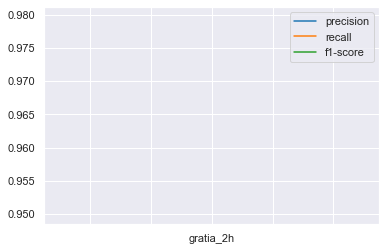

In [103]:
classification_metrics.iloc[:-4,:-1].plot()
fig = plt.gcf()
run['metrics/test_1/classification_metrics'].upload(File.as_image(fig))
#plt.close()

In [50]:
run['metrics/test_1/classification_metrics'].upload(File.as_html(classification_metrics))
print(classification_metrics)

                           precision    recall  f1-score       support
p4mbm_scaled_mixed_halide   0.873569  0.970838  0.919638   7544.000000
others                      0.984415  0.929125  0.955971  14956.000000
accuracy                    0.943111  0.943111  0.943111      0.943111
macro avg                   0.928992  0.949982  0.937805  22500.000000
weighted avg                0.947249  0.943111  0.943789  22500.000000


In [51]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.gcf()

In [52]:
fig = plot_confusion_matrix(cf_matrix, phase_names_1, normalize=False)
run['metrics/test_1/confusion_matrix'].upload(File.as_image(fig))
plt.close()

In [53]:
fig_norm = plot_confusion_matrix(cf_matrix, phase_names_1, normalize=True)
run['metrics/test_1/confusion_matrix_norm'].upload(File.as_image(fig_norm))
plt.close()

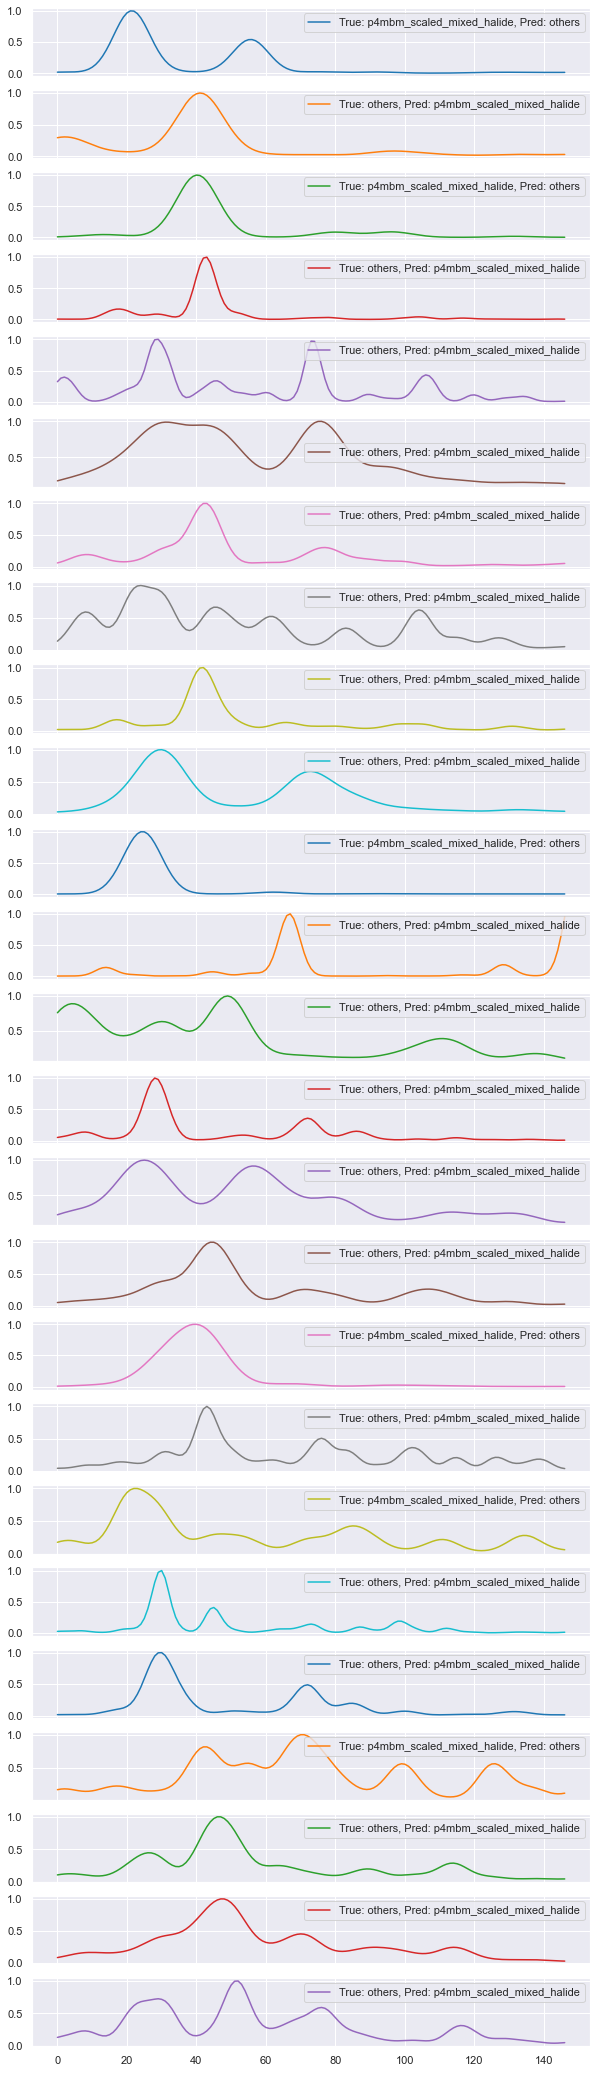

In [65]:
%matplotlib inline
# Plot some of the misclassified data:
bool_predictions = preds.flatten() == test_labels_bin

n_bad = np.count_nonzero(~bool_predictions)
n_max = min(25, n_bad)

fig, axs = plt.subplots(nrows=n_max, figsize = (10, n_max * 1.5), sharex=True)
ax = 0
for i, bool_pred in enumerate(bool_predictions):
    if ax >= n_max:
        break
    if bool_pred == False:
        true_phase = phase_names_1[int(test_labels_bin[i])]
        pred_phase = phase_names_1[int(preds[i])]
        lab = 'True: {}, Pred: {}'.format(true_phase, pred_phase)
        axs[ax].plot(test_data[i,:], label=lab, color=f'C{ax}')
        axs[ax].legend()
        ax += 1

run['metrics/test_1/bad_predictions'].upload(File.as_image(fig))
plt.close()

# Train and test model 2

In [92]:
history = model_2.fit(subtrain_data, subtrain_labels,
          batch_size=batch_size, epochs=epochs,
          callbacks=[neptune_cbk])

704/704 [==============================] - 40s 53ms/step - loss: 0.2188 - accuracy: 0.9048

In [93]:
accuracy_train = model_2.evaluate(subtrain_data, subtrain_labels,)
accuracy_test = model_2.evaluate(subtest_data, subtest_labels,)

468/468 [==============================] - 4s 9ms/step - loss: 0.0961 - accuracy: 0.9654

In [94]:
data = np.vstack([accuracy_train, accuracy_test])
accuracies = pd.DataFrame(data, index=['train', 'test'], columns=['loss', 'accuracy'])
run['metrics/train_2/accuracies_df'].upload(File.as_html(accuracies))
accuracies

,loss,accuracy
train,0.092947,0.966100
test,0.096079,0.965432


In [95]:
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d")

train_ac_str = f"{accuracy_train[1]:.4f}".replace(".", "p")
test_ac_str = f"{accuracy_test[1]:.4f}".replace(".", "p")

In [98]:
name = f'{timestamp}_{cnn_to_use}_{n_phases - 1}nclasses_' \
       f'{epochs}epochs_{batch_size}batchsize__train_{train_data.shape[0]/output_classes:.0f}n_' \
       f'{train_ac_str}ac__test_{test_data.shape[0]/output_classes:.0f}n_' \
       f'{test_ac_str}ac_part2.h5'

model_2.save(name)
run['source_code/model_2/model_name'].log(name)

phases_txt_name = f"phase_names_2_{name.split('.')[0]}"
phase_names_2 = phase_names[1:]
np.save(phases_txt_name, np.array(phase_names_2))
run['source_code/model_2/phase_names'].log(phase_names_2)

model_2.summary(print_fn=lambda x: run['source_code/model_2/model_summary'].log(x))

FileNotFound: File not found: gratia_2h

## Undestanding misclassification in test data

In [104]:
# Get the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd

preds2 = np.round(model_2.predict(subtest_data), 0)
classification_metrics = metrics.classification_report(subtest_labels, preds2,
                                                       target_names=phase_names_2, output_dict=True)
classification_metrics = pd.DataFrame(classification_metrics).T

if len(phase_names_2) == 2:
    cf_matrix = confusion_matrix(subtest_labels, preds2,)
else:
    cf_matrix = confusion_matrix(subtest_labels.argmax(1), preds2.argmax(1),)

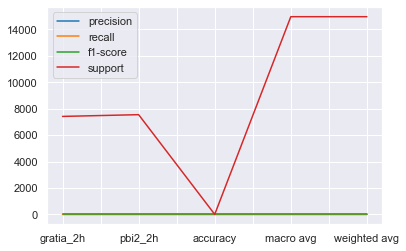

In [110]:
classification_metrics.iloc[:-4,:-1].plot()
fig = plt.gcf()
run['metrics/test_2/classification_metrics'].upload(File.as_image(fig))
#plt.close()

In [111]:
run['metrics/test_2/classification_metrics'].upload(File.as_html(classification_metrics))
print(classification_metrics)

              precision    recall  f1-score       support
gratia_2h      0.979686  0.949946  0.964587   7412.000000
pbi2_2h        0.952246  0.980647  0.966238   7544.000000
accuracy       0.965432  0.965432  0.965432      0.965432
macro avg      0.965966  0.965296  0.965412  14956.000000
weighted avg   0.965845  0.965432  0.965420  14956.000000


In [112]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.gcf()

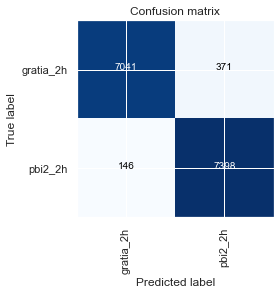

In [113]:
fig = plot_confusion_matrix(cf_matrix, phase_names_2, normalize=False)
run['metrics/test_2/confusion_matrix'].upload(File.as_image(fig))
plt.close()

In [114]:
fig_norm = plot_confusion_matrix(cf_matrix, phase_names_2, normalize=True)
run['metrics/test_2/confusion_matrix_norm'].upload(File.as_image(fig_norm))
plt.close()

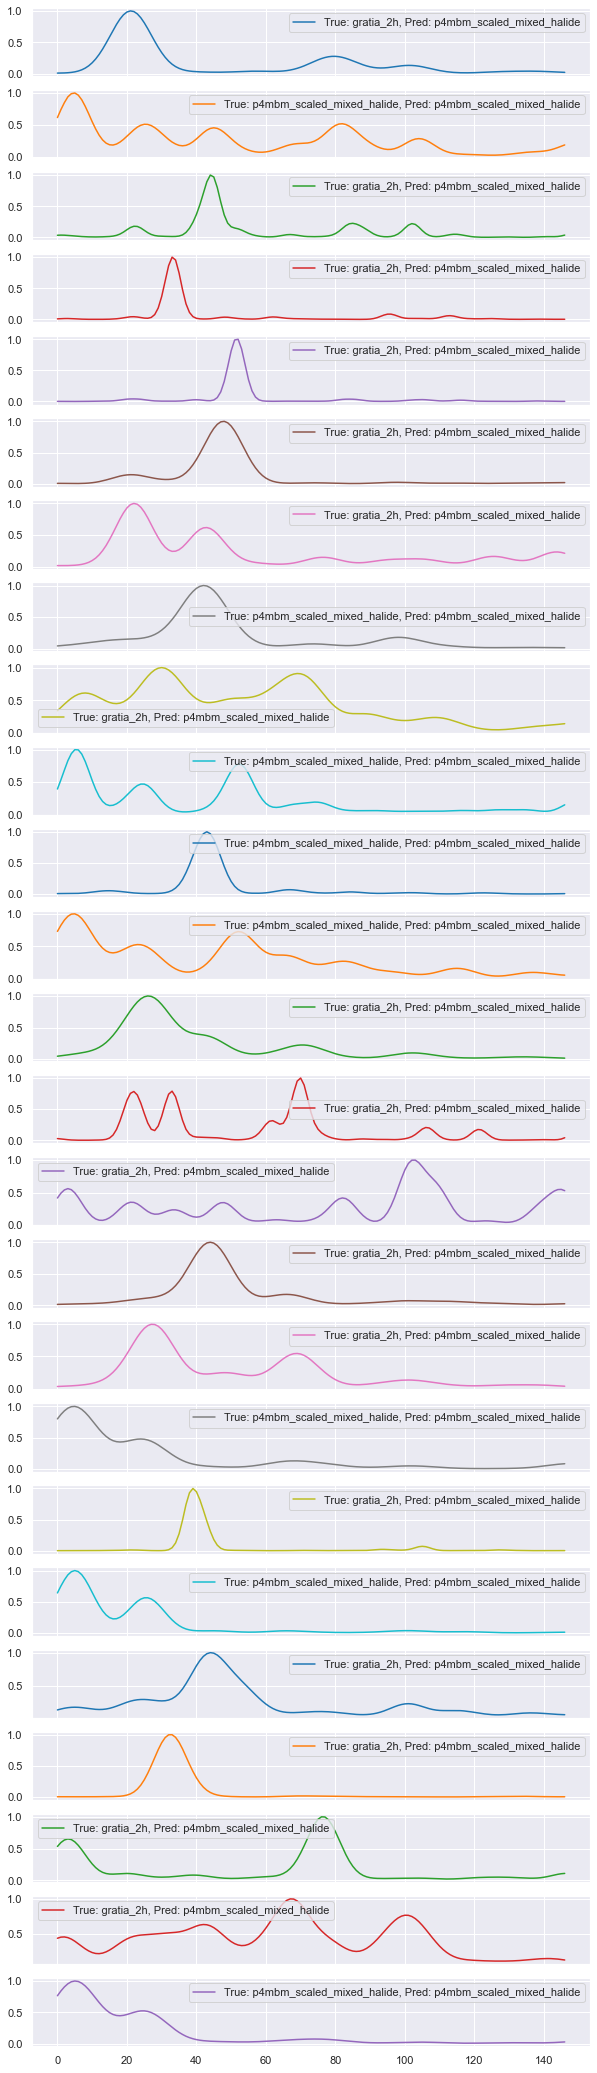

In [115]:
%matplotlib inline
# Plot some of the misclassified data:
if len(phase_names_2) == 2:
    bool_predictions = subtest_labels.flatten() == preds2.flatten()
else:
    bool_predictions = subtest_labels.argmax(1) == preds2.argmax(1)
    
n_bad = np.count_nonzero(~bool_predictions)
n_max = min(25, n_bad)

fig, axs = plt.subplots(nrows=n_max, figsize = (10, n_max * 1.5), sharex=True)
ax = 0
for i, bool_pred in enumerate(bool_predictions):
    if ax >= n_max:
        break
    if bool_pred == False:
        if len(phase_names_2) == 2:
            true_phase = phase_names[int(subtest_labels[i])]
            pred_phase = phase_names[int(preds2[i])]
        else:
            true_phase = phase_names[subtest_labels.argmax(1)[i]]
            pred_phase = phase_names[preds2.argmax(1)[i]]
        lab = 'True: {}, Pred: {}'.format(true_phase, pred_phase)
        axs[ax].plot(test_data[i,:], label=lab, color=f'C{ax}')
        axs[ax].legend()
        ax += 1

run['metrics/test_2/bad_predictions'].upload(File.as_image(fig))
#plt.close()

In [ ]:
run.stop()